## Chapter 7

* 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있음.
* 일련의 예측기를 앙상블(ensemble)이라 하고, 위와 같은 방식의 학습을 앙상블 학습, 이러한 알고리즘을 앙상블 방법이라고 함.
  * ex) 훈련 세트에서 여러 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킨 뒤, 가장 많은 선택을 받은 클래스를 예측으로 삼음.
* 결정 트리의 앙상블을 랜덤 포레스트(random forest)라고 함.

### 투표 기반 분류기

* 정확도가 80%인 여러 분류기를 훈련시켰다고 가정. 더 좋은 분류기를 만들기 위해 각 분류기의 에측을 모아 가장 많이 선택된 클래스를 예측함. 이렇게 다수결로 정해지는 분류기를 직접 투표(hard voting) 분류기라고 함.
* 이러한 방법이 개별 분류기 중 가장 성능이 좋은 것보다 정확도가 높을 경우가 많음.
  * 각 분류기가 약한 학습기(정확도가 낮은 분류기)더라도 분류기가 충분히 많고 다양하다면 강한 학습기(정확도가 높은 학습기)가 될 수 있음.

* 만약, 앞면이 나올 확률이 51%, 뒷면이 49%인 동전을 1000번 던지면, 앞면이 다수가 될 확률은 75%에 가까워짐.

In [1]:
from scipy.stats import binom

1-binom.cdf(499, 1000, 0.51)

0.7467502275561786

In [2]:
# 동전을 10000번 던졌을 때 앞면이 절반 이상 나올 확률
1-binom.cdf(4999, 10000, 0.51)

0.9777976478701533

* 위처럼 51% 정확도를 가진 1000개의 분류기로 앙상블 모델을 구축하여 가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있음.
  * 단, 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 함.
  * 같은 데이터로 훈련시키기 때문에 분류기들이 같은 종류의 오차를 만들기 쉽고, 앙상블의 정확도가 낮아짐.
  * 보통 각기 다른 알고리즘으로 학습시켜 다른 종류의 오차를 만들 가능성을 높이면 앙상블 모델의 정확도가 올라감.

In [3]:
# Moons dataset으로 투표 기반 분류기(VotingClassifier) 생성
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

moons_data_X, moons_data_y = make_moons(n_samples=1000, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(moons_data_X, moons_data_y, test_size=0.2, random_state=42)

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [4]:
# 각 분류기의 정확도 출력
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.82
RandomForestClassifier 0.84
SVC 0.855
VotingClassifier 0.86


> * 투표 기반 분류기의 정확도가 제일 높음.

* 투표 기반 분류기의 모든 분류기가 클래스의 확률을 예측할 수 있으면(<code>predict_proba()</code>를 쓸 수 있으면) 개별 분류기의 예측을 평균을 내어 확률이 가장 높은 클래스를 예측할 수 있고, 이를 간접 투표(soft voting)라고 함.
  * 일반적으로 직접 투표 방식보다 성능이 높음.
  * <code>voting='soft'</code>

In [5]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)        # SVC에서 클래스 확률 추정을 위해서는 probability=True가 필요.

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.82
RandomForestClassifier 0.84
SVC 0.855
VotingClassifier 0.865


### Bagging, Pasting

* 다양한 분류기를 만들기 위해서는 각기 다른 훈련 알고리믖을 사용하거나, 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시킬 수 있음.
* 훈련 세트에서 중복을 허용하여 샘플링하는 방식을 배깅(bagging, bootstrap aggregating), 중복을 허용하지 않으면 페이스팅(pasting)이라고 함.
* 배깅과 페이스팅 모두 같은 훈련 샘플을 여러 예측기에 걸쳐 사용할 수 있음.
  * 배깅만 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있음.
* 모든 예측기의 훈련이 끝나면 각 예측을 모아 새로운 샘플에 대한 예측을 만듦. 수집 함수는 분류일 때는 통계적 최빈값(가장 많은 예측 결과), 회귀에 대해서는 평균을 계산
  * 각 예측기는 원본 훈련 세트로 훈련한 것 보다 훨씬 편향되어있지만 수집 함수를 통과하면 편향과 분산이 모두 감소.
* CPU 코어나 서버에서 병렬로 학습 및 예측이 가능.

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 결정 트리 분류기 500개(n_estimators)의 앙상블을 훈련
# max_samples는 원본 데이터셋에서 샘플링할 데이터 개수
# bootstrap=False로 지정 시 페이스팅 사용
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [7]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

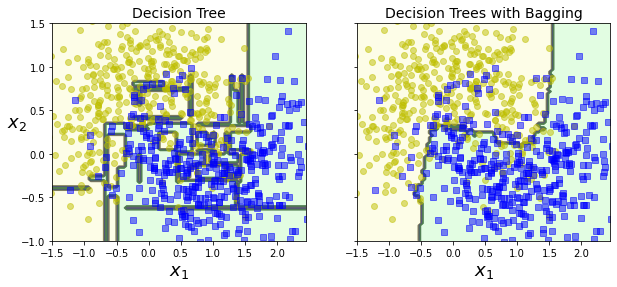

In [8]:
import numpy as np

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

> 앙상블이 비슷한 편향에서 더 적은 분산을 만듦.

* 배깅(부트스트래핑) 사용 시 서브셋의 다양성을 증가시키므로 페이스팅보다 편향이 더 높음.
* 다양성을 추가하면 예측기들의 상간관계를 줄이므로 분산을 감소시킴
* 일반적으로 배깅이 더 선호됨.

* 배깅은 일부 샘플은 한 예측기를 위해 여러 번 샘플링되고(중복을 허용하므로), 어떤 것은 전혀 선택되지 않을 수 있음
* BaggingClassifier는 중복을 허용하여 훈련 세트의 크기만큼인 m개의 샘플은 선택하므로 각 예측기에 훈련 샘플의 63%정도만 샘플링됨.
  * m개의 샘플에서 무작위로 하나를 추출할 때 선택되지 않을 확률은 $ 1-\frac{1}{m} $이고, 이를 m번 반복해도 선택되지 않을 확률은 $ \left(1-\frac{1}{m}\right)^m $이 됨. 여기에 로그를 취한 뒤 로핖탈의 정리를 적용하면 샘플링될 확률은 $ 1-e^{-1}\approx0.63212 $가 됨
* 여기서 선택되지 않은 나머지 37%를 oob(out of bag) sample이라고 함.
* 예측기의 훈련에는 oob 샘플이 사용되지 않으므로 따로 검증 세트를 만들지 않고 oob 샘플을 사용해 평가 가능.
* 앙상블의 평가는 각 예측기의 oob평가를 평균하여 얻음.
  * <code>oob_score=True</code> 시, 자동으로 oob평가를 수행

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=2, oob_score=True
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=2, oob_score=True)

In [10]:
bag_clf.oob_score_

0.8425

In [11]:
# Test set을 이용한 정확도와 비교
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.83

In [12]:
# oob 샘플에 대한 결정 함수의 값
# 두 번째 훈련 샘플에 대해서 양성에 속할 확률은 8%, 음성에 속할 확률은 91%
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.94179894, 0.05820106],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [0.6626506 , 0.3373494 ],
       [0.        , 1.        ]])

### 랜덤 패치, 랜덤 서브스페이스

* BaggingClassifier는 특성 샘플링도 지원.
* <code>max_features, bootstrap_features</code> 매개변수로 조절
* 샘플이 아닌 특성에 대한 샘플링, 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨.
* 이미지와 같은 고차원의 데이터셋을 다룰 때 유용
* 특성과 샘플을 모두 샘플링하는 것을 랜덤 패치(random patches method) 방식, 훈련 샘플을 모두 사용하고 특성은 샘플링하는 방식을 랜덤 서브스페이스 방식(random subspaces method, <code>bootstrap=False, max_samples-1.0, bootstrap_features=True, max_features<1.0</code>) 이라고 함.
* 특성 샘플링 시 더 다양한 예측기를 만들며 편향을 늘리고 분산을 낮춤.

<p>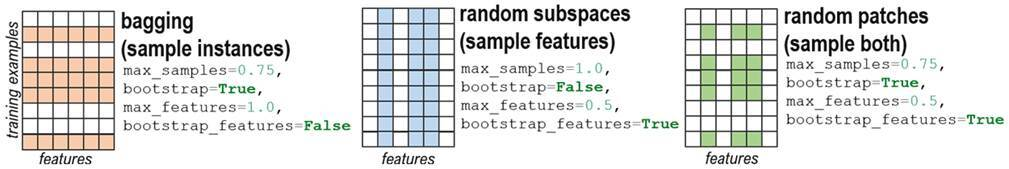</p>

> from https://livebook.manning.com/concept/machine-learning/random-patch

### Random Forest

* 배깅을 적용한 결정 트리의 앙상블
* max_samples를 훈련 세트의 크기로 지정함.
* <code>RandomForestClassifier</code>로 사용 가능.
  * 일부 예외를 제외하고 Decision Tree Classifier의 매개변수와 Bagging Classifier의 매개변수를 모두 가지고 있음
  * 예외 : <code>splitter="best", presort=False, max_samples=1.0, base_estimator=지정된 매개변수를 사용한 DecisionTreeClassifier</code>

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=2)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

* 트리의 노드 분할 시 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중 최적의 특성을 찾는 식으로 무작위성을 주입.
  * 트리가 다양해지며 편향을 손해보지만 분산을 낮춤.

In [18]:
# BaggingClassifier를 이용해 RandomForestClassifier와 유사하게 만든 것
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16)
)

* 랜덤 포레스트에서 트리를 만들 때 무작위로 특성의 서브셋을 만들어 분할에 사용하고, 극단적으로 무작위한 트리의 랜덤 포레스트를 익스트림 랜덤 트리(extremely randomized trees, 또는 extra-trees)라고 함.
  * 편향이 늘어나고 분산을 낮춤.
  * 모든 노드에서 특성마다 가장 최적의 임계값을 찾는 것이 많은 시간이 소요되므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름.
  * <code>ExtraTreesClassifier</code> 사용
  * RandomForestclassifier와 ExtraTreesClassifer는 어떤 것이 더 좋을 지 알 수 없으므로 둘 다 사용하는것이 좋음.

* 랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉬움.
* scikit-learn에서 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도 측정.
* 훈련이 끝난 뒤 특성마다 이 점수를 계산하고, 중요도의 전체 합이 1이 되도록 결과값을 정규화함.
  * <code>feature_importancs_</code>변수에 저장됨.
* 랜덤 포레스트는 특성을 선택할 때 어떤 특성이 중요한지 빠르게 확인할 수 있음.

In [19]:
# Iris dataset으로 특성의 중요도 출력
# 꽃잎의 길이(45%), 너비(41%)가 중요한 특성
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09324391966646539
sepal width (cm) 0.023647971271380443
petal length (cm) 0.41937386783940145
petal width (cm) 0.4637342412227528


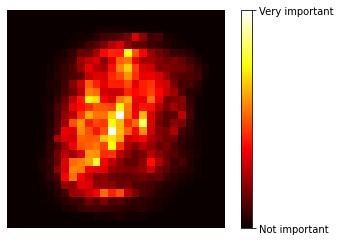

In [20]:
# mnist 데이터셋의 각 픽셀에 대한 중요도를 그래프로 출력

import matplotlib as mpl
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

### Boosting

* 부스팅(boosting, 또는 hypothesis boosting) : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 기법
  * 앞의 모델을 보완해나가면서 일련의 예측기를 학습시킴
  * Adaboost, Gradient Boost로 나뉨

* Adaboost : 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것. 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨.
  * ex) 첫 번째 분류기 훈련 뒤 예측. 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높여 두 번째 분류기에서 다시 훈련 뒤 예측을 만듦. 이러한 방법을 반복하여 계속 가중치를 업데이트함.

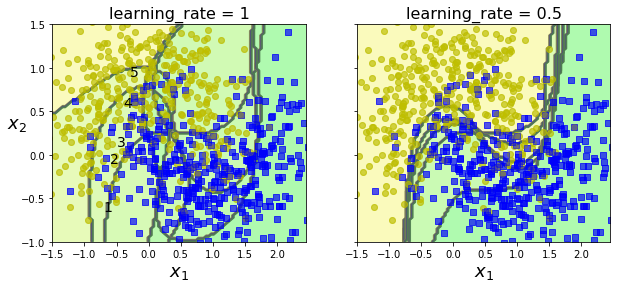

In [24]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

> 첫 번재 분류기에서 많은 샘플을 잘못 분류대 해당 샘플들의 가중치가 높아졌으므로, 두 번째 분류기는 이러한 샘플들에 대한 예측이 더 정확해짐
> 오른쪽 그래프는 학습률만 낮춘 것(잘못 분류된 샘플의 가중치는 왼쪽에 비해 절반 정도만 높아짐)

* 모든 예측기의 훈련이 끝나면 배깅이나 페이스팅과 비슷한 방식으로 예측을 만들지만, 예측기마다 다른 가중치가 적용됨.
* 연속된 학습 기법은 각 예측기를 분할할 수 없으므로 확장성이 떨어짐.

* 각 샘플 가중치 $ w^{(i)} $ 는 초기에 $ \frac{1}{m} $으로 초기화됨. 첫 예측기가 학습된 뒤 가중치가 적용된 에러율 $ r_1 $ 이 훈련 세트에 대해 계산.
$$ r_j = \frac{\sum_{i=1}^mw^{(i)}\;(단, \hat{y}_j^{(i)}\neq y^{(i)}인\;i에\;대해서만)}{\sum_{i=1}^mw^{(i)}}\quad(\hat{y}_j^{(i)}는\;i번째\;샘플에\;대한\;j번쨰\;예측기의\;예측) $$
* 각 예측기의 가중치는 다음과 같이 게산 $$ \alpha_j=\eta\log\frac{1-r_j}{r_j} $$
  * $ \eta $ : 학습률 하이퍼파라미터.
  * 예측기가 정확할수록 가중치가 더 높아지게 됨.
  * 무작위로 예측하는 정도라면 가중치가 0에 가까울 것이고, 그보다 나쁘면 가중치는 음수가 됨.
* AdaBoost 알고리즘은 다음의 식을 이용해 가중치를 업데이트함. 즉, 잘못 분류된 샘플의 가중치 증가
$$ w^{(i)} \leftarrow
\begin{cases}
w^{(i)}, & \text{if}\;\hat{y_j}^{(i)}=y^(i) \\
w^{(i)}\exp\left(\alpha_j\right), & \text{if}\;\hat{y_j}^{(i)}\neq y^(i)
\end{cases} $$
* 이후 모든 샘플의 가중치 정규화($ \sum_{i=1}^mw^{(i)} $ 로 나눔)
* 새 예측기가 업데이트된 가중치를 사용해 훈련한 뒤 위의 과정 반복. 지정된 예측기 개수에 도달하거나 완벽한 예측기가 만들어지면 중단하게 됨.
* 예측 시에는 모든 예측기의 예측을 계산하고 가중치 $ \alpha_j $ 를 더해 예측 결과를 만들어 가중치 합이 가장 큰 클래스가 예측 결과가 됨. $$ \hat{y}(\mathbf{x})=\underset{k}{\text{argmax}}\underset{\hat{y}_j(\mathbf{x})=k}{\sum_{j=1}^N\alpha_j}\quad(N:\;예측기의\;개수) $$

* sklearn에서는 SAMME라는 AdaBoost의 다중 클래스 버전을 사용.
  * 클래스가 두개라면 SAMME는 AdaBoost와 동일
  * 예측기가 클래스의 확률을 추정할 수 있다면 SAMME.R을 사용하고, 예측값 대신 클래스 확률에 기반해 성능이 더 좋음.

In [32]:
# 결정 노드 1개와 leaf노드 두 개로 이루어진 트리를 이용한 AdaBoost.
# 과대적함되었다면 추정기의 수를 줄이거나 규제를 강하게 하면 됨.
from sklearn.ensemble import AdaBoostClassifier

ada_clf_1 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5
)
ada_clf_2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=50, algorithm="SAMME.R", learning_rate=0.5,
)
ada_clf_1.fit(X_train, y_train)
ada_clf_2.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5)

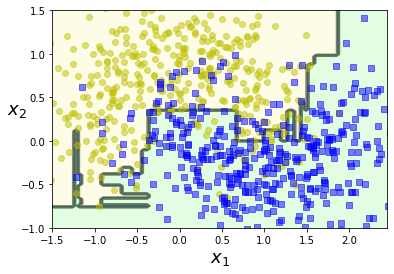

In [33]:
plot_decision_boundary(ada_clf_1, X_train, y_train)

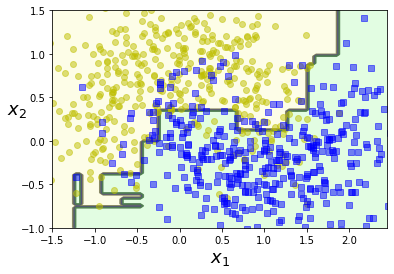

In [34]:
plot_decision_boundary(ada_clf_2, X_train, y_train)

* Gradient Boosting : AdaBoost처럼 예측기에 가중치를 순차적으로 추가하지만 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차(residual error)에 새로운 예측기를 학습시킴.
* 결정 트리를 기반 예측기로 한 회귀 문제를 Gradient tree boosting(또는 gradient boosted regression tree, GBRT)라고 함.

In [37]:
# 첫 번째 예측기에서 잡음이 섞인 2차 곡선 형태 훈련
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X ,y)

DecisionTreeRegressor(max_depth=2)

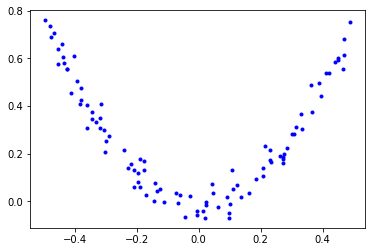

In [42]:
plt.plot(X, y, 'b.')

In [39]:
# 첫 번째 예측기의 잔여 오차에 두 번째 예측기를 훈련
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [43]:
# 세 번째 모델 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [44]:
# 새로운 샘플에 대한 예측을 만들기 위해 모든 트리의 예측을 더함
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [45]:
y_pred

array([0.75026781])

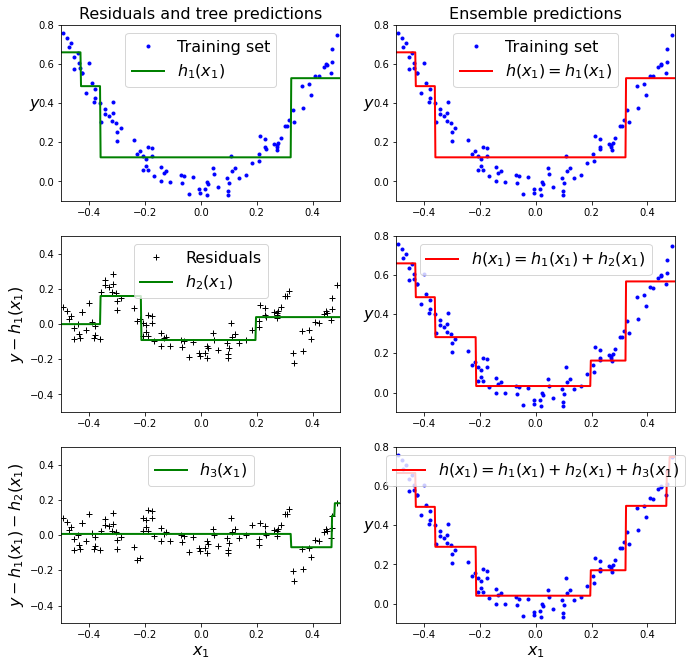

In [46]:
# from https://github.com/rickiepark/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb
# 각 tree의 예측과 앙상블의 예측 비교
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

> * 첫째 행은 앙상블에 트리가 하나밖에 없으므로 두 그래프가 같음 
> * 두 번째 행은 두 번째 트리가 첫 번째 트리의 잔여 오차에 대해 학습됨(앙상블의 예측은 첫 번째와 두 번째 트리의 예측의 합과 같음).
> * 세 번째 행도 마찬가지
> * 트리가 앙상블에 추가될수록 예측이 점차 좋아지는 것을 알 수 있음.

In [47]:
# 위와 동일한 앙상블을 GradientBoostingRegressor로 만든 것.
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)
y_pred_gbrt = gbrt.predict(X_new)

In [48]:
y_pred_gbrt

array([0.75026781])

* <code>learning_rate</code> : 각 트리의 기여 정도 조절. 0.1처럼 낮게 설정하면 많은 트리가 필요하지만 예측이 성능은 좋아짐.
  * 이는 축소(shrinkage)라고 불리는 규제 방법.

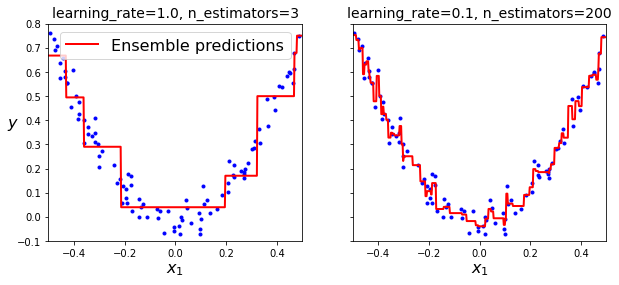

In [50]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

> 오른쪽이 트리가 많아 과대적합됨.

* 최적의 트리 수를 찾기 위해 조기 종료 사용가능.
* <code>staged_predict()</code> 사용.
  * 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 iterator반환.

In [66]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)] # 각 훈련 단계(각 트리)에서 검증 오차 측정.
bst_n_estimators = np.argmin(errors) + 1    # argmin : 최솟값에 해당하는 index 반환. 오차값이 제일 최소가 되는 곳의 index를 반환하게 됨.

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56)

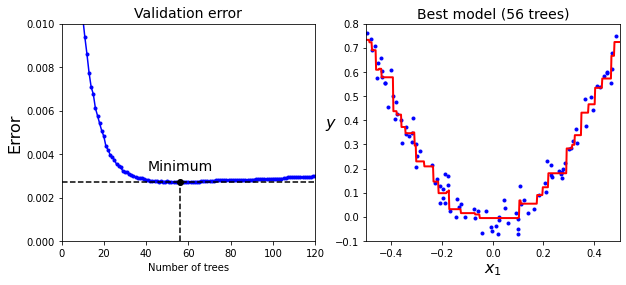

In [67]:
min_error = np.min(errors)
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

In [69]:
# 모든 트리를 훈련시킨 뒤 최소값의 오차를 찾는 것 대신, 훈련을 바로 중지.

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True) # warm_start=True : fit()호출 시, 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줌.

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    # 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 멈춤.
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

* GradientBoostingRegressor는 각 트리 훈련 시 사용할 훈련 샘플의 비율을 지정할 수 있음. 이런 기법을 확률적 그레이디언트 부스팅이라고 함(stochastic gradient boosting)
  * <code>subsample</code> 매개변수 사용. 
  * subsample=0.25라면 각 트리는 샘플의 25%만 학습에 사용함.
  * 편향이 높아지는 대신 분산이 낮아지고, 훈련 속도를 상당히 높여줌.

* <code>loss</code> 를 이용해 다른 비용 함수 지정 가능.
  * deviance : 로지스틱 손실 함수(GradientBoostingClassifier의 기본값)
  * exponential : adaboost에서 사용
  * ls : 최소제곱(GradientBoostingRegressor의 기본값)
  * lad : 최소 절댓값 오차
  * huber : 후버 손실 함수
  * quantile : 사분위수 손실 함수

* XGBoost : 최적화된 그레이디언트 부스팅 구현. (https://github.com/dmlc/xgboost). scikitlearn과 매우 비슷함.
* LightGBM : 히스토그램 기반 그레이디언트 부스팅 구현. (https://lightgbm.readthedocs.io) scikitlearn에서는 HistGradientBoostingClassifier/Regressor 사용가능

In [71]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

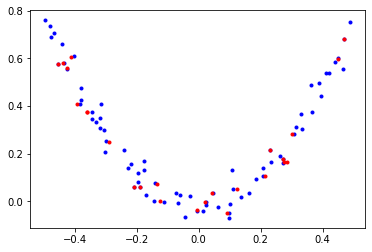

In [74]:
plt.plot(X_train, y_train, "b.")
plt.plot(X_val, y_pred, "r.")

In [77]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)   # 조기 종료
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155


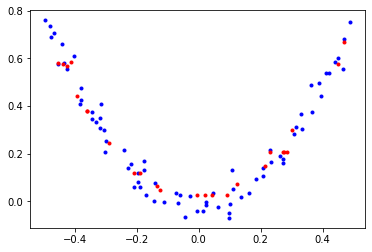

In [78]:
plt.plot(X_train, y_train, "b.")
plt.plot(X_val, y_pred, "r.")

### Stacking

* 스태킹(Stacking) : 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수(직접 투표 등) 대신 취합하는 모델을 훈련시키는 방법.
  * 각 예측기에서 나온 예측값들을 마지막 예측기인 블렌더(blender, 또는 메타 학습기)가 받아 최종 예측을 만듦.
* 블렌더 학습시에는 보통 홀드 아웃 세트(hold-out-set)를 사용함.
  * 훈련 세트를 두 개의 서브셋으로 나눠 첫 번째 서브셋은 첫 번째 layer의 예측을 **훈련**하는데 사용하고, 첫 번째 레이어의 예측기를 사용해 두 번째(holdout) 세트에 대한 **예측**을 만듦.
  * 첫 번째 레이어들의 예측기들은 두 번째 샘플들을 보지 못했으므로 이때 만들어진 예측은 새로운 것들임.
  * 홀드 아웃 세트의 예측 결과를 특성으로, 타깃값(label 등)은 그대로 한 새 훈련 세트를 블렌더로 학습시킴.
* sklearn에서는 StackingClassifier, StackingRegressor 사용.
* https://github.com/Menelau/DESlib 에서 사용가능

------------------

### ex8

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)        # MNIST dataset

In [3]:
from sklearn.model_selection import train_test_split

# train, validation, test 50,000:10,000:10,000 split
X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=10000)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000)

In [10]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.ensemble import VotingClassifier

rfc = RandomForestClassifier(random_state=42, n_jobs=-1)        # Random forest
extra_rfc = ExtraTreesClassifier(random_state=42, n_jobs=-1)    # extra tree
svm_clf = SVC(probability=True, random_state=42)                # svm

# 개별 분류기 training
for clf in [rfc, extra_rfc, svm_clf]:
    print("training... :", clf)
    clf.fit(X_train, y_train)

# hard voting
vote_clf = VotingClassifier(
    estimators=[("rfc", rfc), ("ext_rfc", extra_rfc), ("svc", svm_clf)], voting="hard",
    n_jobs=-1
)
vote_clf.fit(X_train, y_train)

training... : RandomForestClassifier(n_jobs=-1, random_state=42)
training... : ExtraTreesClassifier(n_jobs=-1, random_state=42)
training... : SVC(probability=True, random_state=42)


VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('ext_rfc',
                              ExtraTreesClassifier(n_jobs=-1, random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 n_jobs=-1)

In [11]:
# 개별 분류기 score
for clf in [rfc, extra_rfc, svm_clf]:
    print("score of", clf, ":", clf.score(X_val, y_val))

score of RandomForestClassifier(n_jobs=-1, random_state=42) : 0.9683
score of ExtraTreesClassifier(n_jobs=-1, random_state=42) : 0.9717
score of SVC(probability=True, random_state=42) : 0.9787


In [12]:
# hard vote classifier score
vote_clf.score(X_val, y_val)

0.9737

In [13]:
# soft vote로 변환
vote_clf.voting="soft"

In [14]:
# soft vote score(점수가 더 높음)
vote_clf.score(X_val,y_val)

0.9795

In [16]:
# test set score
vote_clf.score(X_test, y_test)

0.9791

### ex9

In [31]:
import numpy as np

estimators = [rfc, extra_rfc, svm_clf]
X_val_predictions = np.zeros((len(X_val), len(estimators)), dtype=np.float32)

In [32]:
# 각 예측기의 결과들을 모아 새로운 훈련 세트 만들기
for index, estimator in enumerate(estimators):
    X_val_predictions[:,index] = estimator.predict(X_val)

In [33]:
X_val_predictions

array([[8., 8., 8.],
       [7., 7., 7.],
       [7., 7., 7.],
       ...,
       [6., 6., 6.],
       [0., 0., 0.],
       [8., 8., 8.]], dtype=float32)

In [34]:
# 각 샘플에 대한 예측기의 결과가 X, label이 y로 하여 RandomForestClassifier 훈련
blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [36]:
blender.oob_score_

0.9751

In [37]:
# test set으로 predict
from sklearn.metrics import accuracy_score

X_test_predictions = np.zeros((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:,index] = estimator.predict(X_test)

y_pred = blender.predict(X_test_predictions)

In [38]:
accuracy_score(y_test, y_pred)

0.9752